# Imports

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import ImageFont
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from tqdm import tqdm
from glob import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import visualkeras
from tensorflow.keras import layers
import pandas as pd
import tensorflow_model_optimization as tfmot
from tqdm.keras import TqdmCallback

# Data Preparation

In [ ]:
# Constants
RTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\RTM_images'
DTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\DTM_images'
ATM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\ATM_images'

IMG_SIZE = (32, 32)
SEQ_LEN = 5

In [ ]:
# Datasets/
# └── 11G-features/
#     ├── ATM_images/
#     ├── Center_of_Mass/
#     ├── DTM_images/
#     ├── Filtered_Raw_Signals/
#     ├── RFDM_recomputed/
#     │   ├── p0_1/
#     │   │   ├── Circle/
#     │   │   │   ├── sess_0/
#     │   │   │   │   ├── sensor0/
#     │   │   │   │   │   ├── 0.npy
#     │   │   │   │   │   ├── 1.npy
#     │   │   │   │   │   └── ...
#     │   │   │   │   ├── sensor1/
#     │   │   │   │   │   ├── 0.npy
#     │   │   │   │   │   ├── 1.npy
#     │   │   │   │   │   └── ...
#     │   │   │   ├── sess_1/
#     │   │   │   ├── sess_2/
#     │   │   │   ├── sess_3/
#     │   │   │   └── sess_4/
#     │   │   ├── FastSwipeRL/
#     │   │   ├── FingerRub/
#     │   │   ├── FingerSlider/
#     │   │   ├── NoHand/
#     │   │   ├── PalmHold/
#     │   │   ├── PalmTilt/
#     │   │   ├── PinchIndex/
#     │   │   ├── PinchPinkky/
#     │   │   ├── Pull/
#     │   │   ├── Push/
#     │   │   ├── RandomGesture/
#     │   │   └── SlowSwipeRL/
#     │   ├── p0_2/
#     │   ├── p0_3/
#     │   ├── ...
#     │   ├── p0_20/
#     │   ├── p1/
#     │   ├── ...
#     │   └── p25/
#     ├── RTM_images/
#     ├── Signal_Energy_SOR/
#     ├── Signal_Energy_SOT/
#     ├── Signal_Variation_2D/
#     ├── Signal_Variation_SOR/
#     └── Signal_Variation_SOT/

In [3]:
# Function to load image and resize to 32X32X1 - grayscale
def load_and_resize_image(path):
    img = load_img(path, color_mode='grayscale', target_size=(32, 32))
    return img_to_array(img) / 255.0

# Index data correctly with session under person -> session -> gesture
def index_multi_image_sequences(rtm_path, dtm_path, atm_path, seq_len=5, exclude_participants=None):
    all_train_samples, test_samples = [], []
    gesture_set = set()
    exclude_participants = set(exclude_participants or [])

    participants = sorted([p for p in os.listdir(rtm_path) if os.path.isdir(os.path.join(rtm_path, p))])  

    for person in participants:
        print(f"Processing participant: {person}")
        is_test_person = person in exclude_participants
        rtm_person_path = os.path.join(rtm_path, person)

        for session in os.listdir(rtm_person_path):
            rtm_sess_path = os.path.join(rtm_person_path, session)
            if not os.path.isdir(rtm_sess_path):
                continue

            for gesture in os.listdir(rtm_sess_path):
                rtm_gesture_path = os.path.join(rtm_sess_path, gesture)
                dtm_gesture_path = os.path.join(dtm_path, person, session, gesture)
                atm_gesture_path = os.path.join(atm_path, person, session, gesture)

                if not all(map(os.path.isdir, [rtm_gesture_path, dtm_gesture_path, atm_gesture_path])):
                    continue

                gesture_set.add(gesture)

                rtm_files = sorted(glob(os.path.join(rtm_gesture_path, '*.png')))
                dtm_files = sorted(glob(os.path.join(dtm_gesture_path, '*.png')))
                atm_files = sorted(glob(os.path.join(atm_gesture_path, '*.png')))

                num_frames = min(len(rtm_files), len(dtm_files), len(atm_files))
                for i in range(num_frames - seq_len + 1):
                    sample = {
                        'rtm': rtm_files[i:i+seq_len],
                        'dtm': dtm_files[i:i+seq_len],
                        'atm': atm_files[i:i+seq_len],
                        'label': gesture
                    }
                    if is_test_person:
                        test_samples.append(sample)
                    else:
                        all_train_samples.append(sample)

    # 80/20 train/val split
    train_samples, val_samples = train_test_split(
        all_train_samples, test_size=0.2, random_state=42, shuffle=True
    )

    label_map = {gesture: idx for idx, gesture in enumerate(sorted(gesture_set))}
    return train_samples, val_samples, test_samples, label_map

# DataLoader
class MultiRadarSequenceGenerator(Sequence):
    def __init__(self, samples, label_map, batch_size=32, seq_len=SEQ_LEN, shuffle_data=False):
        self.samples = samples
        self.label_map = label_map
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.shuffle_data = shuffle_data
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, index):
        batch_samples = self.samples[index * self.batch_size:(index + 1) * self.batch_size]
        X_rtm, X_dtm, X_atm, y = self.__load_batch(batch_samples)
        return [X_rtm, X_dtm, X_atm], y

    def on_epoch_end(self):
        if self.shuffle_data:
            self.samples = shuffle(self.samples)

    def __load_batch(self, batch_samples):
        X_rtm, X_dtm, X_atm, y = [], [], [], []
        for sample in batch_samples:
            try:
                rtm_seq = [load_and_resize_image(p) for p in sample['rtm']]
                dtm_seq = [load_and_resize_image(p) for p in sample['dtm']]
                atm_seq = [load_and_resize_image(p) for p in sample['atm']]
                if len(rtm_seq) == self.seq_len:
                    X_rtm.append(rtm_seq)
                    X_dtm.append(dtm_seq)
                    X_atm.append(atm_seq)
                    y.append(self.label_map[sample['label']])
            except Exception as e:
                print(f"Error loading sample: {e}")
        return (
            np.array(X_rtm),
            np.array(X_dtm),
            np.array(X_atm),
            np.array(y)
        )

In [4]:
# Index sequences
excluded = {f'p0_{i}' for i in range(15, 21)}  # p0_15 to p0_20
train_samples, val_samples, test_samples, label_map = index_multi_image_sequences(
    RTM_PATH, DTM_PATH, ATM_PATH, seq_len=5, exclude_participants=excluded
)

# Create generators
train_gen = MultiRadarSequenceGenerator(train_samples, label_map, batch_size=256, shuffle_data=True)
val_gen = MultiRadarSequenceGenerator(val_samples, label_map, batch_size=256, shuffle_data=False)

Processing participant: p0_1
Processing participant: p0_10
Processing participant: p0_11
Processing participant: p0_12
Processing participant: p0_13
Processing participant: p0_14
Processing participant: p0_15
Processing participant: p0_16
Processing participant: p0_17
Processing participant: p0_18
Processing participant: p0_19
Processing participant: p0_2
Processing participant: p0_20
Processing participant: p0_3
Processing participant: p0_4
Processing participant: p0_5
Processing participant: p0_6
Processing participant: p0_7
Processing participant: p0_8
Processing participant: p0_9
Processing participant: p1
Processing participant: p10
Processing participant: p11
Processing participant: p12
Processing participant: p13
Processing participant: p14
Processing participant: p15
Processing participant: p16
Processing participant: p17
Processing participant: p18
Processing participant: p19
Processing participant: p2
Processing participant: p20
Processing participant: p21
Processing particip

In [5]:
# how many train samples are there?
print(f"Number of training samples: {len(train_samples)}")
# how many test samples are there?
print(f"Number of val samples: {len(val_samples)}")
# how many test samples are there?
print(f"Number of test samples: {len(test_samples)}")
# what is the shape of the sample?
print(f"Shape of a single sample: {train_gen[0][0][0].shape}")

Number of training samples: 6489
Number of val samples: 1623
Number of test samples: 1166
Shape of a single sample: (256, 5, 32, 32, 1)


# Model

In [6]:
# Build CNN encoder for each input stream
def build_single_cnn(input_shape=(32, 32, 1)):
    input_layer = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    return models.Model(inputs=input_layer, outputs=x)

# Multi-CNN-LSTM model
def build_multi_cnn_lstm(seq_len=5, img_shape=(32, 32, 1), num_classes=13):
    # Inputs
    rtm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="rtm_input")
    dtm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="dtm_input")
    atm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="atm_input")

    cnn_encoder = build_single_cnn(img_shape)

    # Apply TimeDistributed CNN
    rtm_encoded = layers.TimeDistributed(cnn_encoder)(rtm_input)
    dtm_encoded = layers.TimeDistributed(cnn_encoder)(dtm_input)
    atm_encoded = layers.TimeDistributed(cnn_encoder)(atm_input)

    # Fuse the three features
    merged = layers.Concatenate(axis=-1)([rtm_encoded, dtm_encoded, atm_encoded])

    # LSTM
    x = layers.LSTM(128, return_sequences=False)(merged)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=[rtm_input, dtm_input, atm_input], outputs=output)

# Training and Testing

In [7]:
# Custom TQDM callback
class TQDMProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_gen):
        super().__init__()
        self.test_gen = test_gen

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_pbar = tqdm(total=1, desc=f"Epoch {epoch+1}", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_pbar.update(1)
        self.epoch_pbar.close()
        loss, acc = self.model.evaluate(self.test_gen, verbose=0)
        print(f"Epoch {epoch+1}: Test Accuracy = {acc:.4f}")

class BatchCheckpoint(Callback):
    def __init__(self, save_dir, label_map, every_n_batches=100):
        super().__init__()
        self.save_dir = save_dir
        self.every_n_batches = every_n_batches
        self.batch_count = 0
        self.label_map = label_map
        os.makedirs(save_dir, exist_ok=True)

    def on_train_batch_end(self, batch, logs=None):
        self.batch_count += 1
        if self.batch_count % self.every_n_batches == 0:
            filename = os.path.join(self.save_dir, f"batch_{self.batch_count:06d}.h5")
            self.model.save(filename, save_format="tf")
            print(f"Saved model at batch {self.batch_count} to {filename}")

In [8]:
class SaveLossAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, filepath='training_log.txt'):
        super().__init__()
        self.filepath = filepath
        with open(self.filepath, 'w') as f:
            f.write("epoch,loss,accuracy,val_loss,val_accuracy\n")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        line = f"{epoch+1},{logs.get('loss'):.4f},{logs.get('accuracy'):.4f},{logs.get('val_loss'):.4f},{logs.get('val_accuracy'):.4f}\n"
        with open(self.filepath, 'a') as f:
            f.write(line)

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
model = build_multi_cnn_lstm(num_classes=len(label_map))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Checkpoint callbacks
checkpoint_cb = ModelCheckpoint(
    filepath='Models/3_radar_CNN/best_model_epoch{epoch:02d}_valacc{val_accuracy:.4f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

batch_checkpoint_cb = BatchCheckpoint(
    save_dir='Models/3_radar_CNN/batch_checkpoints',
    label_map=label_map,
    every_n_batches=2500
)

log_callback = SaveLossAccuracy(r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN\training_log.txt")

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[
        TQDMProgressCallback(val_gen),
        checkpoint_cb,
        batch_checkpoint_cb,
        log_callback
    ],
    workers=4,
    use_multiprocessing=False,
)
model.save("Models/3_radar_CNN/final_model.h5", save_format="tf")

Epoch 1:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 1/50


26/26 [==============================] - ETA: 0s - loss: 1.7992 - accuracy: 0.4202

Epoch 1: 100%|██████████| 1/1 [00:45<00:00, 45.01s/epoch]


Epoch 1: Test Accuracy = 0.6063

Epoch 1: val_accuracy improved from -inf to 0.60628, saving model to Models/3_radar_CNN\best_model_epoch01_valacc0.6063.h5
26/26 [==============================] - 51s 2s/step - loss: 1.7992 - accuracy: 0.4202 - val_loss: 1.1267 - val_accuracy: 0.6063


c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
Epoch 2:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.9472 - accuracy: 0.6676

Epoch 2: 100%|██████████| 1/1 [00:34<00:00, 34.56s/epoch]


Epoch 2: Test Accuracy = 0.7221

Epoch 2: val_accuracy improved from 0.60628 to 0.72212, saving model to Models/3_radar_CNN\best_model_epoch02_valacc0.7221.h5
26/26 [==============================] - 42s 2s/step - loss: 0.9472 - accuracy: 0.6676 - val_loss: 0.7900 - val_accuracy: 0.7221


Epoch 3:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.7479

Epoch 3: 100%|██████████| 1/1 [00:33<00:00, 33.92s/epoch]


Epoch 3: Test Accuracy = 0.7474

Epoch 3: val_accuracy improved from 0.72212 to 0.74738, saving model to Models/3_radar_CNN\best_model_epoch03_valacc0.7474.h5
26/26 [==============================] - 40s 1s/step - loss: 0.6977 - accuracy: 0.7479 - val_loss: 0.6611 - val_accuracy: 0.7474


Epoch 4:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.5688 - accuracy: 0.7981

Epoch 4: 100%|██████████| 1/1 [00:33<00:00, 33.97s/epoch]


Epoch 4: Test Accuracy = 0.8250

Epoch 4: val_accuracy improved from 0.74738 to 0.82502, saving model to Models/3_radar_CNN\best_model_epoch04_valacc0.8250.h5
26/26 [==============================] - 40s 1s/step - loss: 0.5688 - accuracy: 0.7981 - val_loss: 0.5218 - val_accuracy: 0.8250


Epoch 5:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 5/50
26/26 [==============================] - ETA: 0s - loss: 0.4595 - accuracy: 0.8353

Epoch 5: 100%|██████████| 1/1 [00:34<00:00, 34.72s/epoch]


Epoch 5: Test Accuracy = 0.8355

Epoch 5: val_accuracy improved from 0.82502 to 0.83549, saving model to Models/3_radar_CNN\best_model_epoch05_valacc0.8355.h5
26/26 [==============================] - 41s 2s/step - loss: 0.4595 - accuracy: 0.8353 - val_loss: 0.4726 - val_accuracy: 0.8355


Epoch 6:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 6/50
26/26 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8596

Epoch 6: 100%|██████████| 1/1 [00:34<00:00, 34.29s/epoch]


Epoch 6: Test Accuracy = 0.8521

Epoch 6: val_accuracy improved from 0.83549 to 0.85213, saving model to Models/3_radar_CNN\best_model_epoch06_valacc0.8521.h5
26/26 [==============================] - 40s 1s/step - loss: 0.3891 - accuracy: 0.8596 - val_loss: 0.4121 - val_accuracy: 0.8521


Epoch 7:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 7/50
26/26 [==============================] - ETA: 0s - loss: 0.3381 - accuracy: 0.8779

Epoch 7: 100%|██████████| 1/1 [00:34<00:00, 34.57s/epoch]


Epoch 7: Test Accuracy = 0.8509

Epoch 7: val_accuracy did not improve from 0.85213
26/26 [==============================] - 40s 2s/step - loss: 0.3381 - accuracy: 0.8779 - val_loss: 0.3980 - val_accuracy: 0.8509


Epoch 8:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 8/50
26/26 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.8857

Epoch 8: 100%|██████████| 1/1 [00:35<00:00, 35.30s/epoch]


Epoch 8: Test Accuracy = 0.8755

Epoch 8: val_accuracy improved from 0.85213 to 0.87554, saving model to Models/3_radar_CNN\best_model_epoch08_valacc0.8755.h5
26/26 [==============================] - 43s 2s/step - loss: 0.3080 - accuracy: 0.8857 - val_loss: 0.3276 - val_accuracy: 0.8755


Epoch 9:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 9/50
26/26 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.9149

Epoch 9: 100%|██████████| 1/1 [00:38<00:00, 38.11s/epoch]


Epoch 9: Test Accuracy = 0.8990

Epoch 9: val_accuracy improved from 0.87554 to 0.89895, saving model to Models/3_radar_CNN\best_model_epoch09_valacc0.8990.h5
26/26 [==============================] - 46s 2s/step - loss: 0.2496 - accuracy: 0.9149 - val_loss: 0.2942 - val_accuracy: 0.8990


Epoch 10:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 10/50
26/26 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9276

Epoch 10: 100%|██████████| 1/1 [00:34<00:00, 34.97s/epoch]


Epoch 10: Test Accuracy = 0.9094

Epoch 10: val_accuracy improved from 0.89895 to 0.90943, saving model to Models/3_radar_CNN\best_model_epoch10_valacc0.9094.h5
26/26 [==============================] - 41s 2s/step - loss: 0.2143 - accuracy: 0.9276 - val_loss: 0.2727 - val_accuracy: 0.9094


Epoch 11:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 11/50
26/26 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9405

Epoch 11: 100%|██████████| 1/1 [00:34<00:00, 34.29s/epoch]


Epoch 11: Test Accuracy = 0.9107

Epoch 11: val_accuracy improved from 0.90943 to 0.91066, saving model to Models/3_radar_CNN\best_model_epoch11_valacc0.9107.h5
26/26 [==============================] - 40s 2s/step - loss: 0.1742 - accuracy: 0.9405 - val_loss: 0.2511 - val_accuracy: 0.9107


Epoch 12:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 12/50
26/26 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9464

Epoch 12: 100%|██████████| 1/1 [00:36<00:00, 36.84s/epoch]


Epoch 12: Test Accuracy = 0.9168

Epoch 12: val_accuracy improved from 0.91066 to 0.91682, saving model to Models/3_radar_CNN\best_model_epoch12_valacc0.9168.h5
26/26 [==============================] - 43s 2s/step - loss: 0.1528 - accuracy: 0.9464 - val_loss: 0.2274 - val_accuracy: 0.9168


Epoch 13:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 13/50
26/26 [==============================] - ETA: 0s - loss: 0.1258 - accuracy: 0.9593

Epoch 13: 100%|██████████| 1/1 [00:36<00:00, 36.34s/epoch]


Epoch 13: Test Accuracy = 0.9267

Epoch 13: val_accuracy improved from 0.91682 to 0.92668, saving model to Models/3_radar_CNN\best_model_epoch13_valacc0.9267.h5
26/26 [==============================] - 42s 2s/step - loss: 0.1258 - accuracy: 0.9593 - val_loss: 0.2118 - val_accuracy: 0.9267


Epoch 14:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 14/50
26/26 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9712

Epoch 14: 100%|██████████| 1/1 [00:35<00:00, 35.78s/epoch]


Epoch 14: Test Accuracy = 0.9359

Epoch 14: val_accuracy improved from 0.92668 to 0.93592, saving model to Models/3_radar_CNN\best_model_epoch14_valacc0.9359.h5
26/26 [==============================] - 42s 2s/step - loss: 0.1044 - accuracy: 0.9712 - val_loss: 0.1894 - val_accuracy: 0.9359


Epoch 15:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 15/50
26/26 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9793

Epoch 15: 100%|██████████| 1/1 [00:36<00:00, 36.61s/epoch]


Epoch 15: Test Accuracy = 0.9433

Epoch 15: val_accuracy improved from 0.93592 to 0.94331, saving model to Models/3_radar_CNN\best_model_epoch15_valacc0.9433.h5
26/26 [==============================] - 44s 2s/step - loss: 0.0742 - accuracy: 0.9793 - val_loss: 0.1646 - val_accuracy: 0.9433


Epoch 16:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 16/50
26/26 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9824

Epoch 16: 100%|██████████| 1/1 [00:35<00:00, 35.89s/epoch]


Epoch 16: Test Accuracy = 0.9458

Epoch 16: val_accuracy improved from 0.94331 to 0.94578, saving model to Models/3_radar_CNN\best_model_epoch16_valacc0.9458.h5
26/26 [==============================] - 42s 2s/step - loss: 0.0664 - accuracy: 0.9824 - val_loss: 0.1535 - val_accuracy: 0.9458


Epoch 17:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 17/50
26/26 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9869

Epoch 17: 100%|██████████| 1/1 [00:36<00:00, 36.21s/epoch]


Epoch 17: Test Accuracy = 0.9458

Epoch 17: val_accuracy did not improve from 0.94578
26/26 [==============================] - 42s 2s/step - loss: 0.0538 - accuracy: 0.9869 - val_loss: 0.1599 - val_accuracy: 0.9458


Epoch 18:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 18/50
26/26 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9901

Epoch 18: 100%|██████████| 1/1 [00:36<00:00, 36.74s/epoch]


Epoch 18: Test Accuracy = 0.9476

Epoch 18: val_accuracy improved from 0.94578 to 0.94763, saving model to Models/3_radar_CNN\best_model_epoch18_valacc0.9476.h5
26/26 [==============================] - 43s 2s/step - loss: 0.0443 - accuracy: 0.9901 - val_loss: 0.1573 - val_accuracy: 0.9476


Epoch 19:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 19/50
26/26 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9917

Epoch 19: 100%|██████████| 1/1 [00:42<00:00, 42.88s/epoch]


Epoch 19: Test Accuracy = 0.9563

Epoch 19: val_accuracy improved from 0.94763 to 0.95625, saving model to Models/3_radar_CNN\best_model_epoch19_valacc0.9563.h5
26/26 [==============================] - 51s 2s/step - loss: 0.0383 - accuracy: 0.9917 - val_loss: 0.1314 - val_accuracy: 0.9563


Epoch 20:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 20/50
26/26 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9937

Epoch 20: 100%|██████████| 1/1 [00:40<00:00, 40.25s/epoch]


Epoch 20: Test Accuracy = 0.9489

Epoch 20: val_accuracy did not improve from 0.95625
26/26 [==============================] - 46s 2s/step - loss: 0.0308 - accuracy: 0.9937 - val_loss: 0.1624 - val_accuracy: 0.9489


Epoch 21:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 21/50
26/26 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9971

Epoch 21: 100%|██████████| 1/1 [00:38<00:00, 38.01s/epoch]


Epoch 21: Test Accuracy = 0.9612

Epoch 21: val_accuracy improved from 0.95625 to 0.96118, saving model to Models/3_radar_CNN\best_model_epoch21_valacc0.9612.h5
26/26 [==============================] - 44s 2s/step - loss: 0.0214 - accuracy: 0.9971 - val_loss: 0.1219 - val_accuracy: 0.9612


Epoch 22:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 22/50
26/26 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9958

Epoch 22: 100%|██████████| 1/1 [00:37<00:00, 37.70s/epoch]


Epoch 22: Test Accuracy = 0.9544

Epoch 22: val_accuracy did not improve from 0.96118
26/26 [==============================] - 44s 2s/step - loss: 0.0219 - accuracy: 0.9958 - val_loss: 0.1397 - val_accuracy: 0.9544


Epoch 23:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 23/50
26/26 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9966

Epoch 23: 100%|██████████| 1/1 [00:35<00:00, 35.55s/epoch]


Epoch 23: Test Accuracy = 0.9612

Epoch 23: val_accuracy did not improve from 0.96118
26/26 [==============================] - 42s 2s/step - loss: 0.0198 - accuracy: 0.9966 - val_loss: 0.1301 - val_accuracy: 0.9612


Epoch 24:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 24/50
26/26 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9986

Epoch 24: 100%|██████████| 1/1 [00:35<00:00, 35.31s/epoch]


Epoch 24: Test Accuracy = 0.9686

Epoch 24: val_accuracy improved from 0.96118 to 0.96858, saving model to Models/3_radar_CNN\best_model_epoch24_valacc0.9686.h5
26/26 [==============================] - 41s 2s/step - loss: 0.0157 - accuracy: 0.9986 - val_loss: 0.1191 - val_accuracy: 0.9686


Epoch 25:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 25/50
26/26 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9998

Epoch 25: 100%|██████████| 1/1 [00:36<00:00, 36.68s/epoch]


Epoch 25: Test Accuracy = 0.9692

Epoch 25: val_accuracy improved from 0.96858 to 0.96919, saving model to Models/3_radar_CNN\best_model_epoch25_valacc0.9692.h5
26/26 [==============================] - 43s 2s/step - loss: 0.0093 - accuracy: 0.9998 - val_loss: 0.1061 - val_accuracy: 0.9692


Epoch 26:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 26/50
26/26 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9995

Epoch 26: 100%|██████████| 1/1 [00:36<00:00, 36.72s/epoch]


Epoch 26: Test Accuracy = 0.9680

Epoch 26: val_accuracy did not improve from 0.96919
26/26 [==============================] - 43s 2s/step - loss: 0.0075 - accuracy: 0.9995 - val_loss: 0.1024 - val_accuracy: 0.9680


Epoch 27:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 27/50
26/26 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

Epoch 27: 100%|██████████| 1/1 [00:36<00:00, 36.73s/epoch]


Epoch 27: Test Accuracy = 0.9710

Epoch 27: val_accuracy improved from 0.96919 to 0.97104, saving model to Models/3_radar_CNN\best_model_epoch27_valacc0.9710.h5
26/26 [==============================] - 43s 2s/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.1025 - val_accuracy: 0.9710


Epoch 28:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 28/50
26/26 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9998

Epoch 28: 100%|██████████| 1/1 [00:36<00:00, 36.85s/epoch]


Epoch 28: Test Accuracy = 0.9680

Epoch 28: val_accuracy did not improve from 0.97104
26/26 [==============================] - 43s 2s/step - loss: 0.0045 - accuracy: 0.9998 - val_loss: 0.1096 - val_accuracy: 0.9680


Epoch 29:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 29/50
26/26 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9998

Epoch 29: 100%|██████████| 1/1 [00:36<00:00, 36.09s/epoch]


Epoch 29: Test Accuracy = 0.9717

Epoch 29: val_accuracy improved from 0.97104 to 0.97166, saving model to Models/3_radar_CNN\best_model_epoch29_valacc0.9717.h5
26/26 [==============================] - 42s 2s/step - loss: 0.0045 - accuracy: 0.9998 - val_loss: 0.1009 - val_accuracy: 0.9717


Epoch 30:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 30/50
26/26 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9995

Epoch 30: 100%|██████████| 1/1 [00:36<00:00, 36.56s/epoch]


Epoch 30: Test Accuracy = 0.9636

Epoch 30: val_accuracy did not improve from 0.97166
26/26 [==============================] - 43s 2s/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.1196 - val_accuracy: 0.9636


Epoch 31:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 31/50
26/26 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9877

Epoch 31: 100%|██████████| 1/1 [00:40<00:00, 40.60s/epoch]


Epoch 31: Test Accuracy = 0.9464

Epoch 31: val_accuracy did not improve from 0.97166
26/26 [==============================] - 49s 2s/step - loss: 0.0381 - accuracy: 0.9877 - val_loss: 0.1735 - val_accuracy: 0.9464


Epoch 32:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 32/50
26/26 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9829

Epoch 32: 100%|██████████| 1/1 [00:36<00:00, 36.99s/epoch]


Epoch 32: Test Accuracy = 0.9556

Epoch 32: val_accuracy did not improve from 0.97166
26/26 [==============================] - 43s 2s/step - loss: 0.0536 - accuracy: 0.9829 - val_loss: 0.1530 - val_accuracy: 0.9556


Epoch 33:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 33/50
26/26 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9940

Epoch 33: 100%|██████████| 1/1 [00:36<00:00, 36.03s/epoch]


Epoch 33: Test Accuracy = 0.9655

Epoch 33: val_accuracy did not improve from 0.97166
26/26 [==============================] - 42s 2s/step - loss: 0.0234 - accuracy: 0.9940 - val_loss: 0.1089 - val_accuracy: 0.9655


Epoch 34:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 34/50
26/26 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9972

Epoch 34: 100%|██████████| 1/1 [00:36<00:00, 36.22s/epoch]


Epoch 34: Test Accuracy = 0.9692

Epoch 34: val_accuracy did not improve from 0.97166
26/26 [==============================] - 42s 2s/step - loss: 0.0129 - accuracy: 0.9972 - val_loss: 0.1044 - val_accuracy: 0.9692


Epoch 35:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 35/50
26/26 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9995

Epoch 35: 100%|██████████| 1/1 [00:38<00:00, 38.40s/epoch]


Epoch 35: Test Accuracy = 0.9698

Epoch 35: val_accuracy did not improve from 0.97166
26/26 [==============================] - 46s 2s/step - loss: 0.0058 - accuracy: 0.9995 - val_loss: 0.0960 - val_accuracy: 0.9698


Epoch 36:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 36/50
26/26 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

Epoch 36: 100%|██████████| 1/1 [00:36<00:00, 36.89s/epoch]


Epoch 36: Test Accuracy = 0.9754

Epoch 36: val_accuracy improved from 0.97166 to 0.97535, saving model to Models/3_radar_CNN\best_model_epoch36_valacc0.9754.h5
26/26 [==============================] - 43s 2s/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0894 - val_accuracy: 0.9754


Epoch 37:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 37/50
26/26 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

Epoch 37: 100%|██████████| 1/1 [00:37<00:00, 37.35s/epoch]


Epoch 37: Test Accuracy = 0.9766

Epoch 37: val_accuracy improved from 0.97535 to 0.97659, saving model to Models/3_radar_CNN\best_model_epoch37_valacc0.9766.h5
26/26 [==============================] - 44s 2s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0843 - val_accuracy: 0.9766


Epoch 38:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 38/50
26/26 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

Epoch 38: 100%|██████████| 1/1 [00:36<00:00, 36.21s/epoch]


Epoch 38: Test Accuracy = 0.9747

Epoch 38: val_accuracy did not improve from 0.97659
26/26 [==============================] - 42s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0864 - val_accuracy: 0.9747


Epoch 39:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 39/50
26/26 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

Epoch 39: 100%|██████████| 1/1 [00:36<00:00, 36.39s/epoch]


Epoch 39: Test Accuracy = 0.9772

Epoch 39: val_accuracy improved from 0.97659 to 0.97720, saving model to Models/3_radar_CNN\best_model_epoch39_valacc0.9772.h5
26/26 [==============================] - 43s 2s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0839 - val_accuracy: 0.9772


Epoch 40:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 40/50
26/26 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

Epoch 40: 100%|██████████| 1/1 [00:36<00:00, 36.57s/epoch]


Epoch 40: Test Accuracy = 0.9760

Epoch 40: val_accuracy did not improve from 0.97720
26/26 [==============================] - 43s 2s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0877 - val_accuracy: 0.9760


Epoch 41:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 41/50
26/26 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

Epoch 41: 100%|██████████| 1/1 [00:38<00:00, 38.07s/epoch]


Epoch 41: Test Accuracy = 0.9778

Epoch 41: val_accuracy improved from 0.97720 to 0.97782, saving model to Models/3_radar_CNN\best_model_epoch41_valacc0.9778.h5
26/26 [==============================] - 44s 2s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0834 - val_accuracy: 0.9778


Epoch 42:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 42/50
26/26 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

Epoch 42: 100%|██████████| 1/1 [00:36<00:00, 36.43s/epoch]


Epoch 42: Test Accuracy = 0.9778

Epoch 42: val_accuracy did not improve from 0.97782
26/26 [==============================] - 43s 2s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0838 - val_accuracy: 0.9778


Epoch 43:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 43/50
26/26 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

Epoch 43: 100%|██████████| 1/1 [00:36<00:00, 36.59s/epoch]


Epoch 43: Test Accuracy = 0.9791

Epoch 43: val_accuracy improved from 0.97782 to 0.97905, saving model to Models/3_radar_CNN\best_model_epoch43_valacc0.9791.h5
26/26 [==============================] - 43s 2s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0854 - val_accuracy: 0.9791


Epoch 44:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 44/50
26/26 [==============================] - ETA: 0s - loss: 9.5865e-04 - accuracy: 1.0000

Epoch 44: 100%|██████████| 1/1 [00:36<00:00, 36.69s/epoch]


Epoch 44: Test Accuracy = 0.9760

Epoch 44: val_accuracy did not improve from 0.97905
26/26 [==============================] - 43s 2s/step - loss: 9.5865e-04 - accuracy: 1.0000 - val_loss: 0.0879 - val_accuracy: 0.9760


Epoch 45:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 45/50
26/26 [==============================] - ETA: 0s - loss: 9.6298e-04 - accuracy: 1.0000

Epoch 45: 100%|██████████| 1/1 [00:37<00:00, 37.56s/epoch]


Epoch 45: Test Accuracy = 0.9747

Epoch 45: val_accuracy did not improve from 0.97905
26/26 [==============================] - 45s 2s/step - loss: 9.6298e-04 - accuracy: 1.0000 - val_loss: 0.0850 - val_accuracy: 0.9747


Epoch 46:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 46/50
26/26 [==============================] - ETA: 0s - loss: 9.4688e-04 - accuracy: 1.0000

Epoch 46: 100%|██████████| 1/1 [00:38<00:00, 38.17s/epoch]


Epoch 46: Test Accuracy = 0.9803

Epoch 46: val_accuracy improved from 0.97905 to 0.98028, saving model to Models/3_radar_CNN\best_model_epoch46_valacc0.9803.h5
26/26 [==============================] - 45s 2s/step - loss: 9.4688e-04 - accuracy: 1.0000 - val_loss: 0.0799 - val_accuracy: 0.9803


Epoch 47:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 47/50
26/26 [==============================] - ETA: 0s - loss: 9.6071e-04 - accuracy: 1.0000

Epoch 47: 100%|██████████| 1/1 [00:37<00:00, 37.05s/epoch]


Epoch 47: Test Accuracy = 0.9754

Epoch 47: val_accuracy did not improve from 0.98028
26/26 [==============================] - 43s 2s/step - loss: 9.6071e-04 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9754


Epoch 48:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 48/50
26/26 [==============================] - ETA: 0s - loss: 8.3158e-04 - accuracy: 1.0000

Epoch 48: 100%|██████████| 1/1 [00:36<00:00, 36.80s/epoch]


Epoch 48: Test Accuracy = 0.9772

Epoch 48: val_accuracy did not improve from 0.98028
26/26 [==============================] - 43s 2s/step - loss: 8.3158e-04 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 0.9772


Epoch 49:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 49/50
26/26 [==============================] - ETA: 0s - loss: 7.9400e-04 - accuracy: 1.0000

Epoch 49: 100%|██████████| 1/1 [00:37<00:00, 37.24s/epoch]


Epoch 49: Test Accuracy = 0.9784

Epoch 49: val_accuracy did not improve from 0.98028
26/26 [==============================] - 44s 2s/step - loss: 7.9400e-04 - accuracy: 1.0000 - val_loss: 0.0819 - val_accuracy: 0.9784


Epoch 50:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 50/50
26/26 [==============================] - ETA: 0s - loss: 7.5373e-04 - accuracy: 1.0000

Epoch 50: 100%|██████████| 1/1 [00:37<00:00, 37.88s/epoch]


Epoch 50: Test Accuracy = 0.9766

Epoch 50: val_accuracy did not improve from 0.98028
26/26 [==============================] - 44s 2s/step - loss: 7.5373e-04 - accuracy: 1.0000 - val_loss: 0.0839 - val_accuracy: 0.9766


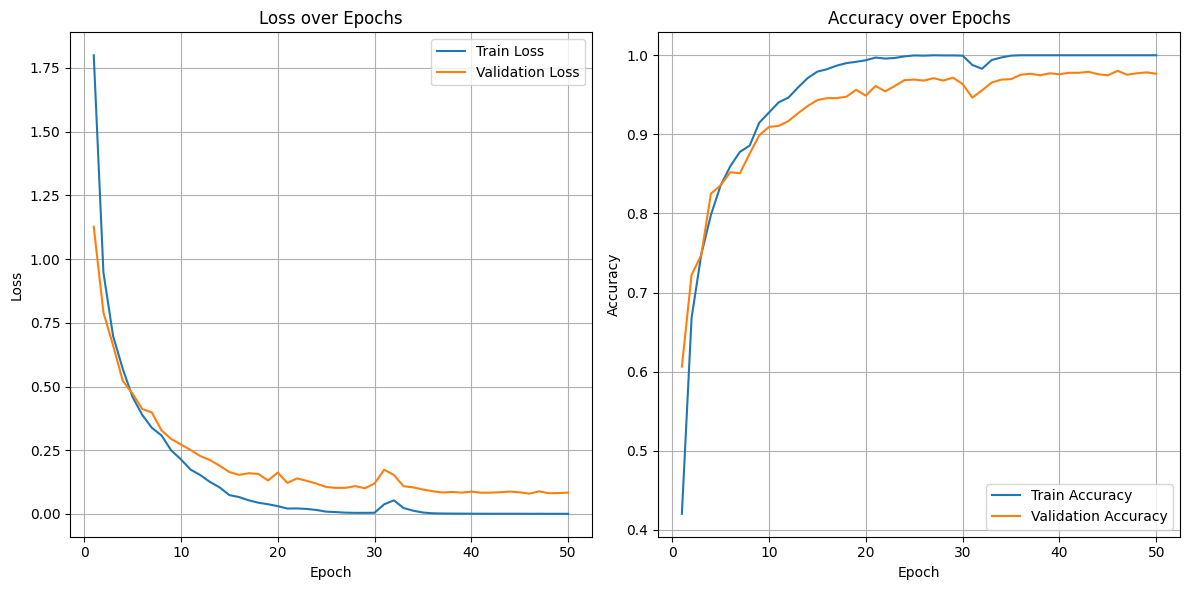

In [10]:
# Load the training log
log_df = pd.read_csv(r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN\training_log.txt")#, sep="\t")

# Plot
if 'epoch' not in log_df.columns:
    log_df['epoch'] = range(1, len(log_df) + 1)

# Plot
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(log_df['epoch'], log_df['loss'], label='Train Loss')
plt.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(log_df['epoch'], log_df['accuracy'], label='Train Accuracy')
plt.plot(log_df['epoch'], log_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Testing

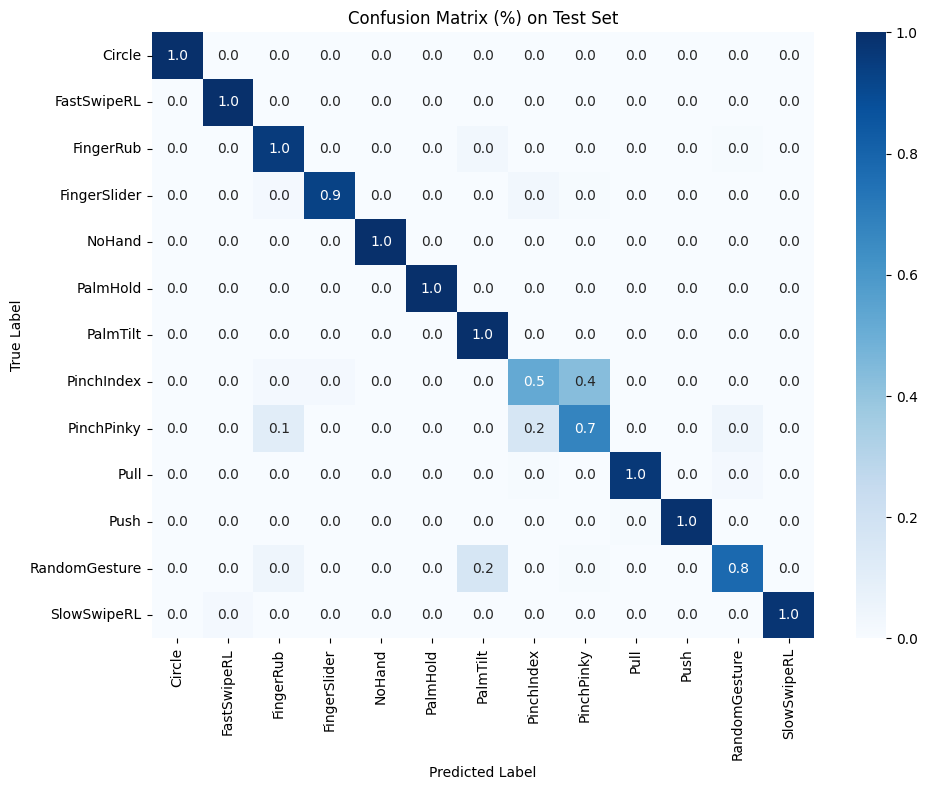

               precision    recall  f1-score   support

       Circle       1.00      1.00      1.00        90
  FastSwipeRL       0.98      1.00      0.99        90
    FingerRub       0.83      0.96      0.89        90
 FingerSlider       0.98      0.93      0.95        87
       NoHand       1.00      1.00      1.00        90
     PalmHold       1.00      1.00      1.00        89
     PalmTilt       0.83      1.00      0.91        90
   PinchIndex       0.71      0.52      0.60        90
   PinchPinky       0.60      0.68      0.64        90
         Pull       0.99      0.97      0.98        90
         Push       1.00      0.99      0.99        90
RandomGesture       0.91      0.78      0.84        90
  SlowSwipeRL       1.00      0.98      0.99        90

     accuracy                           0.91      1166
    macro avg       0.91      0.91      0.91      1166
 weighted avg       0.91      0.91      0.91      1166



In [12]:
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

best_model_path = r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN\best_model_epoch46_valacc0.9803.h5'
model = tf.keras.models.load_model(best_model_path)

# Predict on test generator
y_true = []
y_pred = []

for X, y in test_gen:
    preds = model.predict(X, verbose=0)
    y_true.extend(y)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True)
gesture_names = list(label_map.keys())

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on Test Set')
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=gesture_names))

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rtm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 dtm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 atm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 5, 128)               524832    ['rtm_input[0][0]']           
 ributed)                                                                                   

In [14]:
print(model.layers[1].dtype)  #

float32


# Coversion to TFlite

In [15]:
model = tf.keras.models.load_model(
    r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN\best_model_epoch46_valacc0.9803.h5'
)

# Define input signature for LSTM-safe tracing
# @tf.function(input_signature=[
#     tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="rtm_input"),
#     tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="dtm_input"),
#     tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="atm_input")
# ])
# def wrapped_model(rtm, dtm, atm):
#     return model([rtm, dtm, atm])

# # Get concrete function
# concrete_func = wrapped_model.get_concrete_function()

# Set up converter
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Keep everything float32
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert
tflite_model = converter.convert()

# Save
save_path = "mmWave_orig_float32.tflite"
with open(save_path, "wb") as f:
    f.write(tflite_model)

print("Float32 TFLite model saved successfully")
print(f"Model size: {os.path.getsize(save_path) / 1024:.2f} KB")

INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmp3fp6f8iv\assets


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmp3fp6f8iv\assets


Float32 TFLite model saved successfully
Model size: 3128.57 KB


# Float 16 Quantizatoin

In [29]:
# Load your model
best_model_path = r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN\best_model_epoch46_valacc0.9803.h5'
model = tf.keras.models.load_model(best_model_path)

# Wrap the model in a tf.function with a defined input signature
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="rtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="dtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="atm_input")
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])

# Extract a concrete function
concrete_func = wrapped_model.get_concrete_function()

# Set up the converter from the concrete function
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Needed for models with LSTM
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Keep float32 I/O for compatibility (optional)
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert the model
try:
    tflite_model_fp16 = converter.convert()
    save_path = "mmWave_orig_float16.tflite"
    with open(save_path, "wb") as f:
        f.write(tflite_model_fp16)
    print("Float16 quantization successful")
    print(f"Model size: {os.path.getsize(save_path) / 1024:.2f} KB")
except Exception as e:
    print(f"Float16 quantization failed: {str(e)}")

Float16 quantization successful
Model size: 1571.89 KB


In [30]:
interpreter = tf.lite.Interpreter(model_path=r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\mmWave_orig_float16.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [31]:
for i, d in enumerate(input_details):
    print(f"Input {i}: shape={d['shape']}, dtype={d['dtype']}, quant={d['quantization']}")

for i, d in enumerate(output_details):
    print(f"Output {i}: shape={d['shape']}, dtype={d['dtype']}, quant={d['quantization']}")

Input 0: shape=[ 1  5 32 32  1], dtype=<class 'numpy.float32'>, quant=(0.0, 0)
Input 1: shape=[ 1  5 32 32  1], dtype=<class 'numpy.float32'>, quant=(0.0, 0)
Input 2: shape=[ 1  5 32 32  1], dtype=<class 'numpy.float32'>, quant=(0.0, 0)
Output 0: shape=[ 1 13], dtype=<class 'numpy.float32'>, quant=(0.0, 0)


In [32]:
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

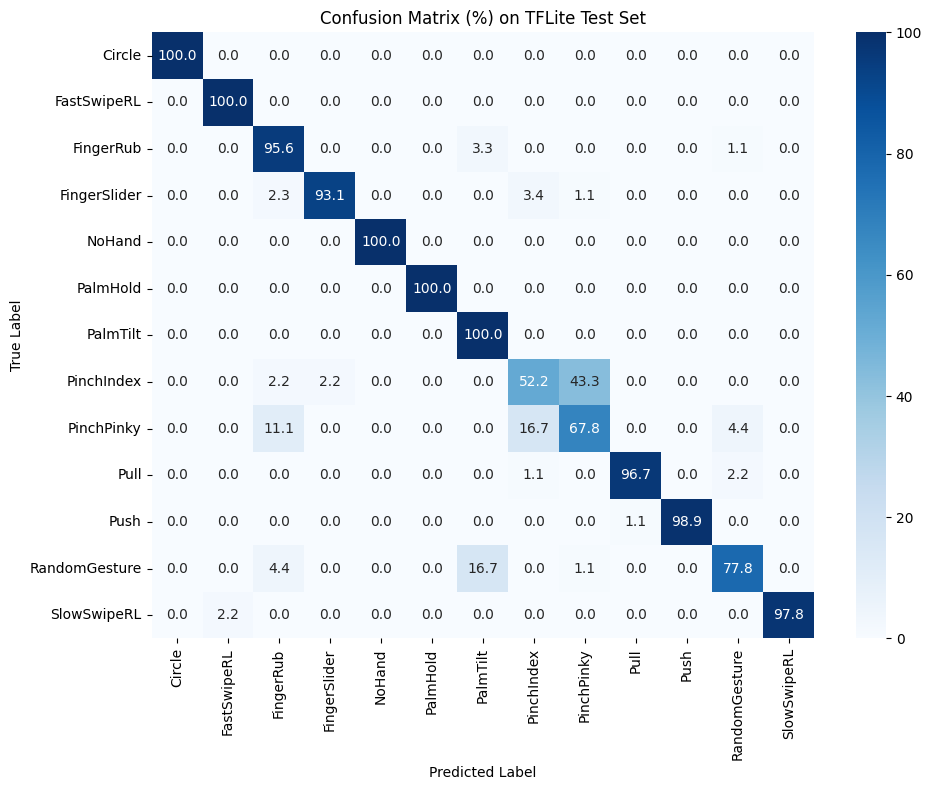

               precision    recall  f1-score   support

       Circle       1.00      1.00      1.00        90
  FastSwipeRL       0.98      1.00      0.99        90
    FingerRub       0.83      0.96      0.89        90
 FingerSlider       0.98      0.93      0.95        87
       NoHand       1.00      1.00      1.00        90
     PalmHold       1.00      1.00      1.00        89
     PalmTilt       0.83      1.00      0.91        90
   PinchIndex       0.71      0.52      0.60        90
   PinchPinky       0.60      0.68      0.64        90
         Pull       0.99      0.97      0.98        90
         Push       1.00      0.99      0.99        90
RandomGesture       0.91      0.78      0.84        90
  SlowSwipeRL       1.00      0.98      0.99        90

     accuracy                           0.91      1166
    macro avg       0.91      0.91      0.91      1166
 weighted avg       0.91      0.91      0.91      1166



In [34]:
def run_tflite_inference(rtm, dtm, atm):
    interpreter.set_tensor(input_details[0]['index'], rtm.astype(input_details[0]['dtype']))
    interpreter.set_tensor(input_details[1]['index'], dtm.astype(input_details[1]['dtype']))
    interpreter.set_tensor(input_details[2]['index'], atm.astype(input_details[2]['dtype']))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Collect predictions
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    batch_size = X_batch[0].shape[0]
    for i in range(batch_size):
        rtm = X_batch[0][i:i+1]  # shape: (1, 5, 32, 32, 3)
        dtm = X_batch[1][i:i+1]
        atm = X_batch[2][i:i+1]
        output = run_tflite_inference(rtm, dtm, atm)
        y_pred.append(np.argmax(output))
        y_true.append(y_batch[i])

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Evaluate: confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
gesture_names = list(label_map.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on TFLite Test Set')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=gesture_names))

# Quantization int8

In [37]:
# Load your model
best_model_path = r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN\best_model_epoch46_valacc0.9803.h5'
model = tf.keras.models.load_model(best_model_path)

# Wrap in tf.function with fixed input signature
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="rtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="dtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="atm_input")
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])

concrete_func = wrapped_model.get_concrete_function()

# Define representative dataset for calibration
def representative_dataset():
    for X_batch, _ in test_gen:  # test_gen must be defined
        for i in range(min(len(X_batch[0]), 100)):  # limit to 100 samples
            rtm = X_batch[0][i:i+1].astype(np.float32)
            dtm = X_batch[1][i:i+1].astype(np.float32)
            atm = X_batch[2][i:i+1].astype(np.float32)
            yield [rtm, dtm, atm]

# Create TFLite converter
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# LSTM-safe settings
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    # tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# 5. Convert
try:
    tflite_model_int8 = converter.convert()
    save_path = "bb_quantized_model_int8.tflite"
    with open(save_path, "wb") as f:
        f.write(tflite_model_int8)
    print("INT8 quantization successful")
    print(f"Model size: {os.path.getsize(save_path) / 1024:.2f} KB")
except Exception as e:
    print(f"INT8 quantization failed: {str(e)}")


INT8 quantization failed: Could not translate MLIR to FlatBuffer. UNKNOWN: c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py:695:1: error: 'tf.TensorListReserve' op is neither a custom op nor a flex op
    self._concrete_variable_creation_fn = tracing_compilation.trace_function(
^
c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compilation.py:178:1: note: called from
    concrete_function = _maybe_define_function(
^
c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compilation.py:283:1: note: called from
        concrete_function = _create_concrete_function(
^
c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compilation.py:310:1: note: called from
  traced_func_graph = func_graph_module.func_graph_from_py_func(
^
c:\Users\i

In [26]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\aa_quantized_model_int8.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [27]:
print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'rtm_input', 'index': 0, 'shape': array([ 1,  5, 32, 32,  1]), 'shape_signature': array([ 1,  5, 32, 32,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'dtm_input', 'index': 1, 'shape': array([ 1,  5, 32, 32,  1]), 'shape_signature': array([ 1,  5, 32, 32,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'atm_input', 'index': 2, 'shape': array([ 1,  5, 32, 32,  1]), 'shape_signature': array([ 1,  5, 32, 32,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}

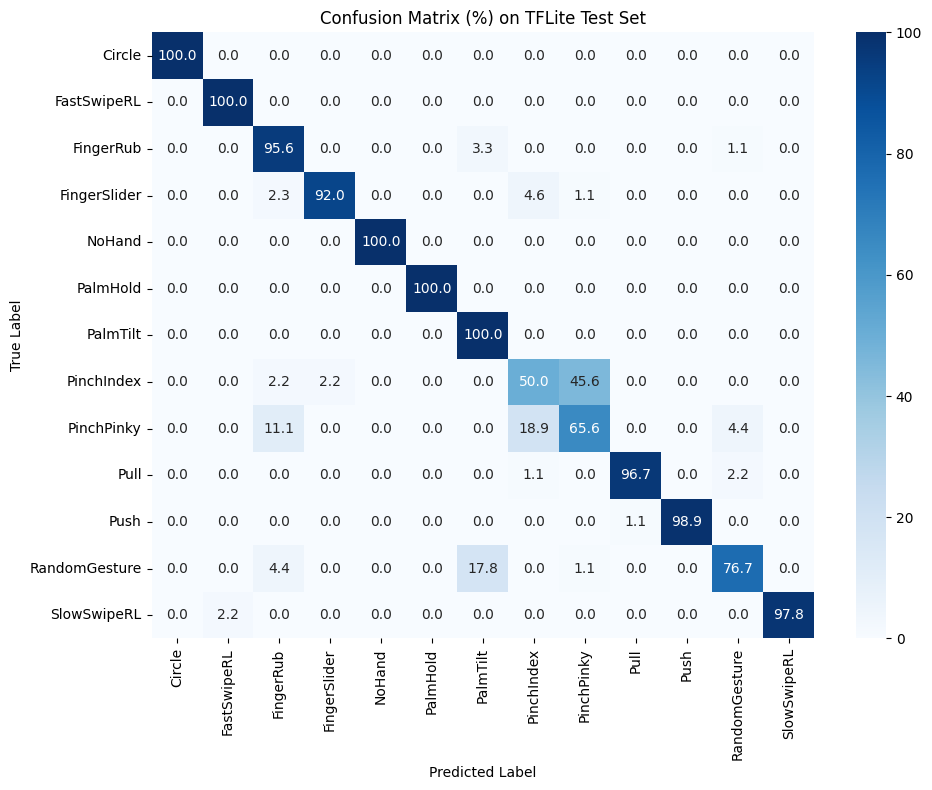

               precision    recall  f1-score   support

       Circle       1.00      1.00      1.00        90
  FastSwipeRL       0.98      1.00      0.99        90
    FingerRub       0.83      0.96      0.89        90
 FingerSlider       0.98      0.92      0.95        87
       NoHand       1.00      1.00      1.00        90
     PalmHold       1.00      1.00      1.00        89
     PalmTilt       0.83      1.00      0.90        90
   PinchIndex       0.67      0.50      0.57        90
   PinchPinky       0.58      0.66      0.61        90
         Pull       0.99      0.97      0.98        90
         Push       1.00      0.99      0.99        90
RandomGesture       0.91      0.77      0.83        90
  SlowSwipeRL       1.00      0.98      0.99        90

     accuracy                           0.90      1166
    macro avg       0.90      0.90      0.90      1166
 weighted avg       0.90      0.90      0.90      1166



In [28]:
def run_tflite_inference(rtm, dtm, atm):
    interpreter.set_tensor(input_details[0]['index'], rtm.astype(input_details[0]['dtype']))
    interpreter.set_tensor(input_details[1]['index'], dtm.astype(input_details[1]['dtype']))
    interpreter.set_tensor(input_details[2]['index'], atm.astype(input_details[2]['dtype']))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Collect predictions
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    batch_size = X_batch[0].shape[0]
    for i in range(batch_size):
        rtm = X_batch[0][i:i+1]  # shape: (1, 5, 32, 32, 1)
        dtm = X_batch[1][i:i+1]
        atm = X_batch[2][i:i+1]
        output = run_tflite_inference(rtm, dtm, atm)
        y_pred.append(np.argmax(output))
        y_true.append(y_batch[i])

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Evaluate: confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
gesture_names = list(label_map.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on TFLite Test Set')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=gesture_names))

# Conversion to TFLite of Pruned Model

In [7]:
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

In [12]:
model_path = r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\Good_Models\h5_models\mmWave_orig_pruned_float32.h5'
pruned_model = tf.keras.models.load_model(model_path)
model = tfmot.sparsity.keras.strip_pruning(pruned_model)

In [14]:
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="rtm"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="dtm"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="atm"),
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])
concrete_func = wrapped_model.get_concrete_function()
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = []  # No quantization (pure float32)

tflite_model = converter.convert()

# Save
with open("mmWave_orig_pruned_float32.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved: mmWave_orig_pruned_float32.tflite")

Saved: mmWave_orig_pruned_float32.tflite


# Float16 Quantization for pruned model

In [ ]:
model_path = r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\Good_Models\h5_models\mmWave_orig_pruned_float32.h5'
pruned_model = tf.keras.models.load_model(model_path)
model = tfmot.sparsity.keras.strip_pruning(pruned_model)

In [19]:
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="rtm"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="dtm"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="atm"),
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])
concrete_func = wrapped_model.get_concrete_function()

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enable float16 quantization
converter.target_spec.supported_types = [tf.float16]

# Still allow float32 inputs/outputs for compatibility
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert
tflite_model_fp16 = converter.convert()
with open("mmWave_orig_pruned_float16.tflite", "wb") as f:
    f.write(tflite_model_fp16)

print("Saved: mmWave_orig_pruned_float16.tflite")


Saved: mmWave_orig_pruned_float16.tflite


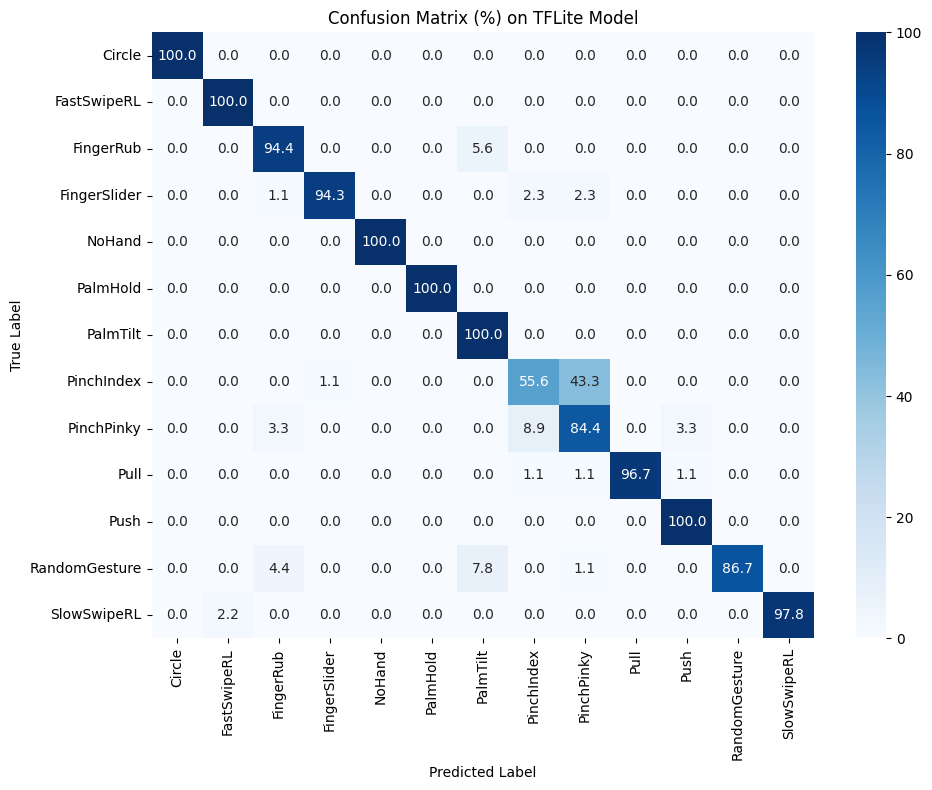


Classification Report:
               precision    recall  f1-score   support

       Circle     1.0000    1.0000    1.0000        90
  FastSwipeRL     0.9783    1.0000    0.9890        90
    FingerRub     0.9140    0.9444    0.9290        90
 FingerSlider     0.9880    0.9425    0.9647        87
       NoHand     1.0000    1.0000    1.0000        90
     PalmHold     1.0000    1.0000    1.0000        89
     PalmTilt     0.8824    1.0000    0.9375        90
   PinchIndex     0.8197    0.5556    0.6623        90
   PinchPinky     0.6387    0.8444    0.7273        90
         Pull     1.0000    0.9667    0.9831        90
         Push     0.9574    1.0000    0.9783        90
RandomGesture     1.0000    0.8667    0.9286        90
  SlowSwipeRL     1.0000    0.9778    0.9888        90

     accuracy                         0.9305      1166
    macro avg     0.9368    0.9306    0.9299      1166
 weighted avg     0.9366    0.9305    0.9297      1166



In [ ]:
interpreter = tf.lite.Interpreter(model_path="mmWave_orig_pruned_float16.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    batch_size = len(y_batch)
    
    for i in range(batch_size):
        input_data = [
            X[i:i+1].astype(np.float32)
            for X in X_batch
        ]
        
        # Set input tensors
        for idx, detail in enumerate(input_details):
            interpreter.set_tensor(detail['index'], input_data[idx])

        interpreter.invoke()
        
        # Get output
        output = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output[0])

        y_true.append(y_batch[i])
        y_pred.append(predicted_label)

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Reverse label_map to get names
inv_label_map = {v: k for k, v in label_map.items()}
gesture_names = [inv_label_map[i] for i in sorted(inv_label_map)]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on TFLite Model')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=gesture_names, digits=4))


# Pruning for int8 model

In [6]:
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

In [31]:
def count_prunable_params(model):
    total_params = 0
    layer_info = []

    def collect_prunable_layers(layer):
        nonlocal total_params

        # Handle TimeDistributed or wrapper layers
        if isinstance(layer, tf.keras.layers.TimeDistributed):
            return collect_prunable_layers(layer.layer)
        elif isinstance(layer, tf.keras.Model):  # Handle nested models
            for sublayer in layer.layers:
                collect_prunable_layers(sublayer)
        elif isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            params = layer.count_params()
            total_params += params
            layer_info.append((layer.name, params))
    
    for layer in model.layers:
        collect_prunable_layers(layer)

    print("=== Prunable Layer Summary ===")
    for name, params in layer_info:
        print(f"{name}: {params:,} parameters")
    print(f"Total prunable parameters: {total_params:,}")

# Usage
model = tf.keras.models.load_model(
    r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\Good_Models\mmWave_orig_float32.h5"
)
count_prunable_params(model)

=== Prunable Layer Summary ===
conv2d_14: 1,216 parameters
dense_42: 524,416 parameters
conv2d_14: 1,216 parameters
dense_42: 524,416 parameters
conv2d_14: 1,216 parameters
dense_42: 524,416 parameters
dense_43: 8,256 parameters
dense_44: 845 parameters
Total prunable parameters: 1,585,997


In [ ]:
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.5,
    begin_step=0,
    end_step=1000
)

# === Recursive pruning ===
def prune_recursively(layer):
    if isinstance(layer, tf.keras.models.Sequential):
        return tf.keras.Sequential([prune_recursively(l) for l in layer.layers])
    elif isinstance(layer, tf.keras.Model):
        return tf.keras.models.clone_model(layer, clone_function=prune_recursively)
    elif isinstance(layer, tf.keras.layers.TimeDistributed):
        layer.layer = prune_recursively(layer.layer)
        return layer
    elif isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, pruning_schedule)
    else:
        return layer

# === Clone and prune model ===
model_for_pruning = tf.keras.models.clone_model(model, clone_function=prune_recursively)
model_for_pruning.build(model.input_shape)

# === Copy weights recursively ===
def copy_weights_recursive(orig_layer, pruned_layer):
    if hasattr(orig_layer, 'layers') and hasattr(pruned_layer, 'layers'):
        for ol, pl in zip(orig_layer.layers, pruned_layer.layers):
            copy_weights_recursive(ol, pl)
    elif hasattr(orig_layer, 'layer') and hasattr(pruned_layer, 'layer'):
        copy_weights_recursive(orig_layer.layer, pruned_layer.layer)
    else:
        try:
            pruned_layer.set_weights(orig_layer.get_weights())
        except Exception as e:
            print(f"Could not copy weights for {pruned_layer.name}: {e}")

copy_weights_recursive(model, model_for_pruning)

# === Compile ===
model_for_pruning.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === Required pruning callback ===
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir="./prune_logs")
]

# === Train on CPU ===
with tf.device('/CPU:0'):
    model_for_pruning.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=callbacks
    )

# === Strip pruning wrappers ===
stripped_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
stripped_model.save("pruned_model_final.h5")

Epoch 1/5
26/26 [==============================] - 48s 2s/step - loss: 0.1364 - accuracy: 0.9593 - val_loss: 0.1380 - val_accuracy: 0.9495
Epoch 2/5
26/26 [==============================] - 41s 2s/step - loss: 0.0150 - accuracy: 0.9965 - val_loss: 0.1001 - val_accuracy: 0.9655
Epoch 3/5
26/26 [==============================] - 41s 2s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0805 - val_accuracy: 0.9778
Epoch 4/5
26/26 [==============================] - 40s 2s/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0707 - val_accuracy: 0.9778
Epoch 5/5
26/26 [==============================] - 39s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0675 - val_accuracy: 0.9815


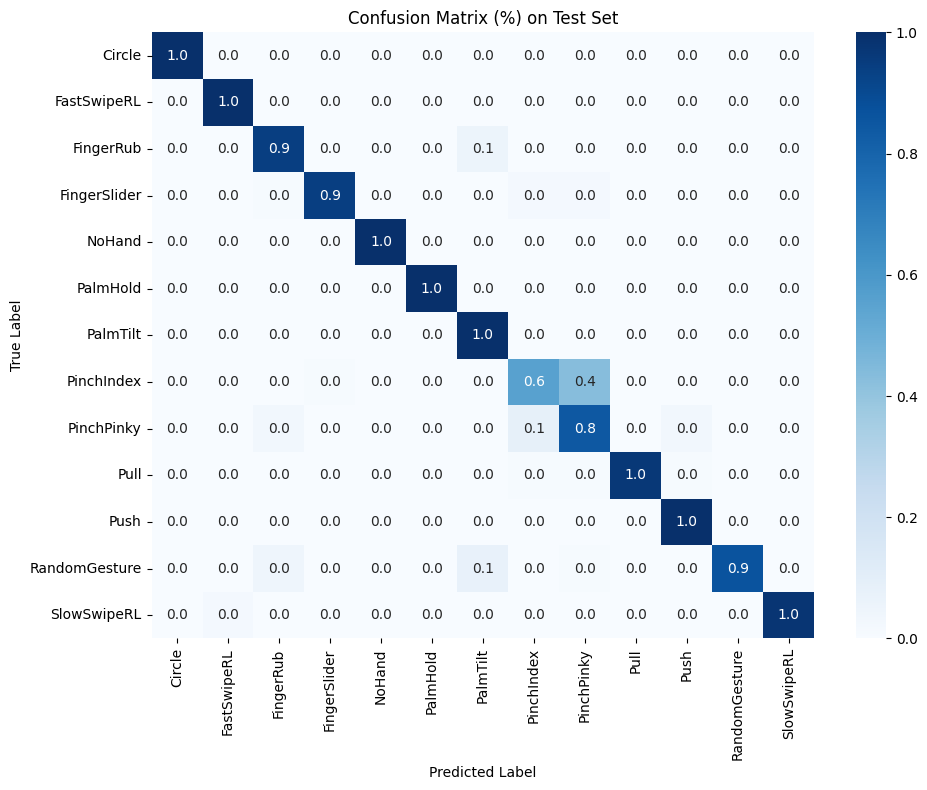

               precision    recall  f1-score   support

       Circle       1.00      1.00      1.00        90
  FastSwipeRL       0.98      1.00      0.99        90
    FingerRub       0.91      0.94      0.93        90
 FingerSlider       0.99      0.94      0.96        87
       NoHand       1.00      1.00      1.00        90
     PalmHold       1.00      1.00      1.00        89
     PalmTilt       0.88      1.00      0.94        90
   PinchIndex       0.82      0.56      0.66        90
   PinchPinky       0.64      0.84      0.73        90
         Pull       1.00      0.97      0.98        90
         Push       0.96      1.00      0.98        90
RandomGesture       1.00      0.87      0.93        90
  SlowSwipeRL       1.00      0.98      0.99        90

     accuracy                           0.93      1166
    macro avg       0.94      0.93      0.93      1166
 weighted avg       0.94      0.93      0.93      1166



In [ ]:
model = tf.keras.models.load_model("pruned_model_final.h5")
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

best_model_path = r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\Models\3_radar_CNN\final_model.h5'
model = tf.keras.models.load_model("pruned_model_final.h5")

# Predict on test generator
y_true = []
y_pred = []

for X, y in test_gen:
    preds = model.predict(X, verbose=0)
    y_true.extend(y)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True)
gesture_names = list(label_map.keys())

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on Test Set')
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=gesture_names))

In [ ]:
model_path = r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\Good_Models\mmWave_pruned_model_float32.h5'

In [ ]:
# === 1. Dynamically get PruneLowMagnitude class ===
dummy = tfmot.sparsity.keras.prune_low_magnitude(tf.keras.layers.Dense(1), input_shape=(1,))
PruneLowMagnitude = type(dummy)

# === 2. Load the model with custom object mapping ===
model = tf.keras.models.load_model(
    r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\Good_Models\mmWave_pruned_model_float32.h5',
    custom_objects={'PruneLowMagnitude': PruneLowMagnitude}
)

# === 3. Strip pruning wrappers (critical before converting) ===
model = tfmot.sparsity.keras.strip_pruning(model)

# === 4. Wrap model in concrete function ===
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="rtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="dtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="atm_input")
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])

concrete_func = wrapped_model.get_concrete_function()

# === 5. Define representative dataset ===
def representative_dataset():
    for X_batch, _ in test_gen:  # Ensure this is defined
        for i in range(min(len(X_batch[0]), 100)):
            rtm = X_batch[0][i:i+1].astype(np.float32)
            dtm = X_batch[1][i:i+1].astype(np.float32)
            atm = X_batch[2][i:i+1].astype(np.float32)
            yield [rtm, dtm, atm]

# === 6. Convert to INT8 TFLite ===
converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [concrete_func], model  # Pass `model` as `trackable_obj` to avoid the warning
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# === 7. Convert and save ===
tflite_model = converter.convert()
with open("pruned_quantized_model_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted to INT8 and saved.")

In [67]:
best_model_path = r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\Good_Models\mmWave_orig_float32.h5'
model = tf.keras.models.load_model(best_model_path)
# Count weights
total_weights = 0
nonzero_weights = 0

for layer in model.layers:
    for weight in layer.get_weights():
        total_weights += weight.size
        nonzero_weights += np.count_nonzero(weight)

# Compute storage assuming INT8 (1 byte per weight)
theoretical_size_bytes = nonzero_weights  # 1 byte per non-zero
theoretical_size_kb = theoretical_size_bytes / 1024

# Optional: full model size if fully dense INT8
full_dense_size_kb = total_weights / 1024

print(f"Estimated model size (pruned, INT8): {theoretical_size_kb:.2f} KB")
print(f"Theoretical dense INT8 size: {full_dense_size_kb:.2f} KB")

Estimated model size (pruned, INT8): 1805.33 KB
Theoretical dense INT8 size: 1805.33 KB
